In [356]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import math
import time
import random

In [357]:
base_data = pd.read_pickle('base_data.pkl')
print(len(base_data))

136


In [358]:
highest_starting_index = max(df.index[0] for df in base_data.values())
lowest_ending_index = min(df.index[-1] for df in base_data.values())

print("Highest starting index value:", highest_starting_index)
print("Lowest ending index value:", lowest_ending_index)

Highest starting index value: 1672527600
Lowest ending index value: 1725140700


In [342]:
def remove_extreme_dataframes(one_week_dfs, n, m):
    # Filter out empty DataFrames
    valid_dfs = {key: df for key, df in one_week_dfs.items() if not df.empty}
    
    if not valid_dfs:
        # If all DataFrames are empty, return an empty dictionary
        return {}

    # Sort dataframes by their starting index value
    sorted_by_start = sorted(valid_dfs.items(), key=lambda item: item[1].index[0])
    
    # Sort dataframes by their ending index value
    sorted_by_end = sorted(valid_dfs.items(), key=lambda item: item[1].index[-1])
    
    # Remove n dataframes with the highest starting index value
    to_remove_start = sorted_by_start[-n:] if n > 0 else []
    
    # Remove m dataframes with the lowest ending index value
    to_remove_end = sorted_by_end[:m] if m > 0 else []
    
    # Create a set of keys to remove
    keys_to_remove = set(key for key, _ in to_remove_start + to_remove_end)
    
    # Remove the dataframes from one_week_dfs
    one_week_dfs = {key: df for key, df in valid_dfs.items() if key not in keys_to_remove}
    
    return one_week_dfs


def longest_shared_continuous_period(dataframes_dict, column_name, tolerance):
    """
    Finds the longest shared continuous period for all DataFrames 
    where there are no NaN values in a specific column, with tolerance for short gaps.

    Parameters:
    dataframes_dict (dict): Dictionary containing pandas DataFrames.
    column_name (str): Column name to check for NaN values.
    tolerance (int): The maximum number of consecutive rows with NaN values allowed.

    Returns:
    dict: Dictionary with cropped DataFrames of the longest continuous shared period.
    """
    def valid_indices(df, col, tol):
        # Mark rows with NaN in the specified column
        is_nan = df[col].isna()
        
        # Identify gaps that are tolerable
        mask = is_nan.rolling(window=tol+1, min_periods=1).sum() <= tol
        
        # Find valid continuous ranges
        valid_blocks = mask.astype(int).diff().fillna(0).ne(0).cumsum()
        valid_periods = df.groupby(valid_blocks).apply(lambda x: len(x) if mask.loc[x.index].all() else 0)
        max_period = valid_periods.idxmax()
        
        # Get the indices of the longest valid period
        return df[valid_blocks == max_period].index

    # Find valid indices for each DataFrame
    valid_indices_dict = {
        key: valid_indices(df, column_name, tolerance) for key, df in dataframes_dict.items()
    }
    
    # Find the intersection of all valid index ranges
    shared_indices = set(valid_indices_dict[next(iter(dataframes_dict))])
    for indices in valid_indices_dict.values():
        shared_indices &= set(indices)
    shared_indices = sorted(shared_indices)
    
    # Trim each DataFrame to the shared indices
    result = {key: df.loc[shared_indices] for key, df in dataframes_dict.items()}
    return result

result = longest_shared_continuous_period(base_data, column_name='traffic_flow', tolerance=4900)


In [343]:
for tolerance in range(initial_tolerance, 0, -tolerance_step):
    print(f"Tolerance: {tolerance}")
    result = longest_shared_continuous_period(base_data, column_name='traffic_flow', tolerance=tolerance)
    
    if not result or all(df.empty for df in result.values()):  # Skip if all DataFrames are empty
        print(f"No valid data for tolerance {tolerance}")
        continue
    
    for n in range(21):
        for m in range(21):
            temp_one_week_dfs = remove_extreme_dataframes(result.copy(), n, m)
            
            if temp_one_week_dfs:  # Check if temp_one_week_dfs is not empty
                if all(not df.empty for df in temp_one_week_dfs.values()):  # Ensure no DataFrame is empty
                    highest_starting_index = max(df.index[0] for df in temp_one_week_dfs.values())
                    lowest_ending_index = min(df.index[-1] for df in temp_one_week_dfs.values())
                    duration_days = ((lowest_ending_index - highest_starting_index) / 3600) / 24
                    print(f"n = {n}, m = {m}, Duration in days = {duration_days}")


Tolerance: 4900
n = 0, m = 0, Duration in days = 48.020833333333336
n = 0, m = 1, Duration in days = 48.020833333333336
n = 0, m = 2, Duration in days = 48.020833333333336
n = 0, m = 3, Duration in days = 48.020833333333336
n = 0, m = 4, Duration in days = 48.020833333333336
n = 0, m = 5, Duration in days = 48.020833333333336
n = 0, m = 6, Duration in days = 48.020833333333336
n = 0, m = 7, Duration in days = 48.020833333333336
n = 0, m = 8, Duration in days = 48.020833333333336
n = 0, m = 9, Duration in days = 48.020833333333336
n = 0, m = 10, Duration in days = 48.020833333333336
n = 0, m = 11, Duration in days = 48.020833333333336
n = 0, m = 12, Duration in days = 48.020833333333336
n = 0, m = 13, Duration in days = 48.020833333333336
n = 0, m = 14, Duration in days = 48.020833333333336
n = 0, m = 15, Duration in days = 48.020833333333336
n = 0, m = 16, Duration in days = 48.020833333333336
n = 0, m = 17, Duration in days = 48.020833333333336
n = 0, m = 18, Duration in days = 48.020

KeyboardInterrupt: 

In [324]:
sizes = {key: df.shape[0] for key, df in result.items()}
lowest_size = min(sizes.values())
biggest_size = max(sizes.values())

print("Lowest size of dataframe:", lowest_size)
print("Biggest size of dataframe:", biggest_size)

Lowest size of dataframe: 4611
Biggest size of dataframe: 4611


In [325]:
highest_starting_index = max(df.index[0] for df in result.values())
lowest_ending_index = min(df.index[-1] for df in result.values())

print("Highest starting index value:", highest_starting_index)
print("Lowest ending index value:", lowest_ending_index)
print(((lowest_ending_index - highest_starting_index)/3600)/24)

Highest starting index value: 1704063600
Lowest ending index value: 1708212600
48.020833333333336


In [326]:
def remove_extreme_dataframes(one_week_dfs, n, m):
    # Sort dataframes by their starting index value
    sorted_by_start = sorted(one_week_dfs.items(), key=lambda item: item[1].index[0])
    
    # Sort dataframes by their ending index value
    sorted_by_end = sorted(one_week_dfs.items(), key=lambda item: item[1].index[-1])
    
    # Remove n dataframes with the highest starting index value
    to_remove_start = sorted_by_start[-n:]
    
    # Remove m dataframes with the lowest ending index value
    to_remove_end = sorted_by_end[:m]
    
    # Create a set of keys to remove
    keys_to_remove = set(key for key, _ in to_remove_start + to_remove_end)
    
    # Remove the dataframes from one_week_dfs
    one_week_dfs = {key: df for key, df in one_week_dfs.items() if key not in keys_to_remove}
    
    return one_week_dfs

max_durations = {}

for total in range(1, 50):  # Since n ranges from 0 to 19 and m ranges from 0 to 17, the maximum total is 36
    max_duration = -1
    best_n, best_m = None, None
    
    for n in range(0, 50):
        for m in range(0, 50):
            if n + m == total:
                temp_one_week_dfs = remove_extreme_dataframes(base_data.copy(), n, m)
                
                if temp_one_week_dfs:  # Check if temp_one_week_dfs is not empty
                    highest_starting_index = max(df.index[0] for df in temp_one_week_dfs.values())
                    lowest_ending_index = min(df.index[-1] for df in temp_one_week_dfs.values())
                    duration_days = ((lowest_ending_index - highest_starting_index) / 3600) / 24

                    if duration_days > max_duration:
                        max_duration = duration_days
                        best_n, best_m = n, m

    if max_duration >= 0:
        max_durations[total] = (best_n, best_m, max_duration)

# Print the results
for total, (best_n, best_m, max_duration) in max_durations.items():
    print(f"Total (n + m) = {total}, n = {best_n}, m = {best_m}, Duration in days = {max_duration}")

Total (n + m) = 1, n = 1, m = 0, Duration in days = 608.9479166666666
Total (n + m) = 2, n = 1, m = 1, Duration in days = 608.9479166666666
Total (n + m) = 3, n = 1, m = 2, Duration in days = 608.9479166666666
Total (n + m) = 4, n = 1, m = 3, Duration in days = 608.9479166666666
Total (n + m) = 5, n = 1, m = 4, Duration in days = 608.9479166666666
Total (n + m) = 6, n = 1, m = 5, Duration in days = 608.9479166666666
Total (n + m) = 7, n = 1, m = 6, Duration in days = 608.9479166666666
Total (n + m) = 8, n = 1, m = 7, Duration in days = 608.9479166666666
Total (n + m) = 9, n = 1, m = 8, Duration in days = 608.9479166666666
Total (n + m) = 10, n = 1, m = 9, Duration in days = 608.9479166666666
Total (n + m) = 11, n = 1, m = 10, Duration in days = 608.9479166666666
Total (n + m) = 12, n = 1, m = 11, Duration in days = 608.9479166666666
Total (n + m) = 13, n = 1, m = 12, Duration in days = 608.9479166666666
Total (n + m) = 14, n = 1, m = 13, Duration in days = 608.9479166666666
Total (n + 

In [327]:
n = 21  # Number of dataframes to remove with the highest starting index value
m = 0  # Number of dataframes to remove with the lowest ending index value
one_week_dfs = remove_extreme_dataframes(result, n, m)

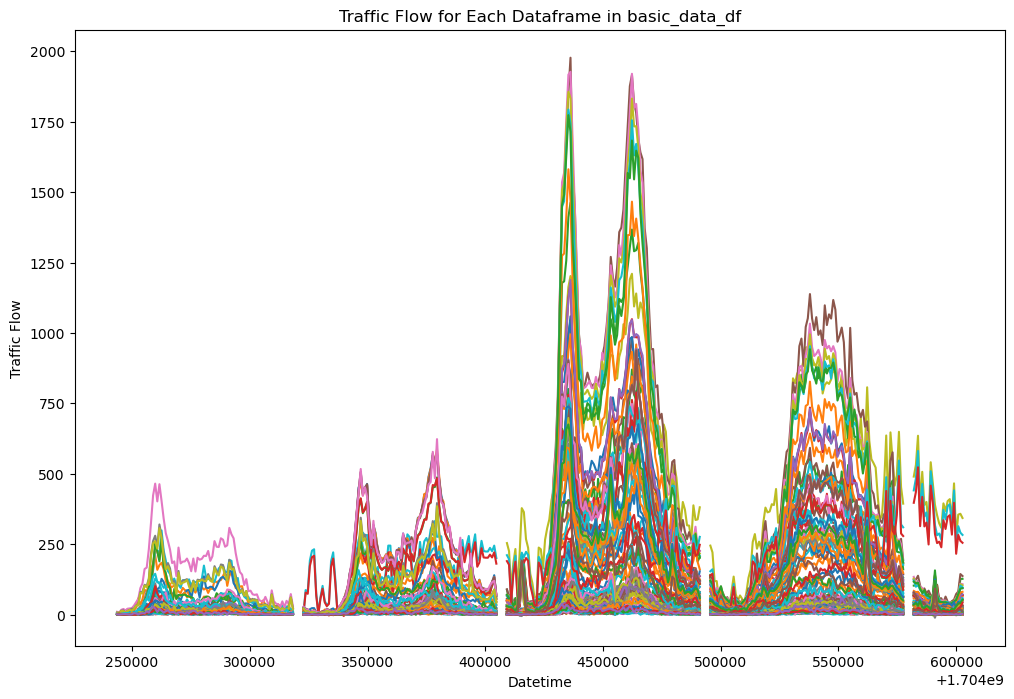

In [328]:
plt.figure(figsize=(12, 8))

for key, df in one_week_dfs.items():
    plt.plot(df.index[200:600], df['traffic_flow'][200:600], label=str(key))

plt.xlabel('Datetime')
plt.ylabel('Traffic Flow')
plt.title('Traffic Flow for Each Dataframe in basic_data_df')
#plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.show()

In [329]:
highest_starting_index = max(df.index[0] for df in one_week_dfs.values())
lowest_ending_index = min(df.index[-1] for df in one_week_dfs.values())

print("Highest starting index value:", highest_starting_index)
print("Lowest ending index value:", lowest_ending_index)
print(((lowest_ending_index - highest_starting_index)/3600)/24)
print(len(one_week_dfs))

Highest starting index value: 1704063600
Lowest ending index value: 1708212600
48.020833333333336
115


In [330]:
for key in one_week_dfs.keys():
    one_week_dfs[key] = one_week_dfs[key].loc[highest_starting_index:lowest_ending_index]

In [331]:
# Select 10 random keys from one_week_dfs
random_keys = random.sample(list(one_week_dfs.keys()), 10)

# Print the shape of the dataframes corresponding to the random keys
for key in random_keys:
    print(f"Shape of dataframe {key}: {one_week_dfs[key].shape}")

Shape of dataframe (561737.0, 6328657.0): (4611, 6)
Shape of dataframe (556242.0, 6340624.0): (4611, 6)
Shape of dataframe (558880.0, 6323318.0): (4611, 6)
Shape of dataframe (555341.0, 6318418.0): (4611, 6)
Shape of dataframe (553084.0, 6313171.0): (4611, 6)
Shape of dataframe (561694.0, 6328595.0): (4611, 6)
Shape of dataframe (558753.0, 6320685.0): (4611, 6)
Shape of dataframe (555308.0, 6318304.0): (4611, 6)
Shape of dataframe (558465.0, 6323359.0): (4611, 6)
Shape of dataframe (556333.0, 6341247.0): (4611, 6)
